In [1]:
import numpy as np
import pandas as pd
%matplotlib widget
import matplotlib.pyplot as plt

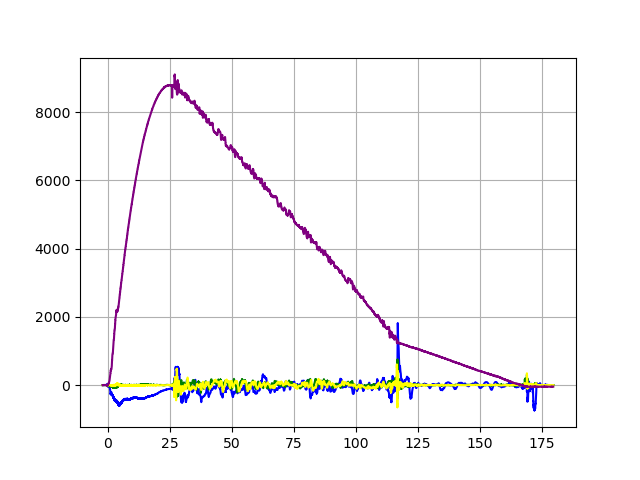

In [2]:
df_hr = pd.read_csv('HighRateData.csv')
df_lr = pd.read_csv('LowRateData.csv')

plt.clf()             # Clear the figure
#plt.plot(df_lr['Flight_Time_(s)'], df_lr['Future_Angle_(deg)'], color = 'red')
#plt.plot(df_lr['Flight_Time_(s)'], df_lr['Tilt_Angle_(deg)'], color = 'orange')
plt.plot(df_hr['Flight_Time_(s)'], df_hr['Gyro_X'], color = 'blue')
plt.plot(df_hr['Flight_Time_(s)'], df_hr['Gyro_Y'], color = 'green')
plt.plot(df_hr['Flight_Time_(s)'], df_hr['Gyro_Z'], color = 'yellow')
plt.plot(df_lr['Flight_Time_(s)'], df_lr['Baro_Altitude_AGL_(feet)'], color = 'purple')
#plt.axhline(y=5, color='yellow', linestyle='--', label='y = 5')
plt.grid()
plt.show()


### Let's find at which time the apogee ocurred

26.8
We are just interested in the first 26.78 seconds of flight
26.78


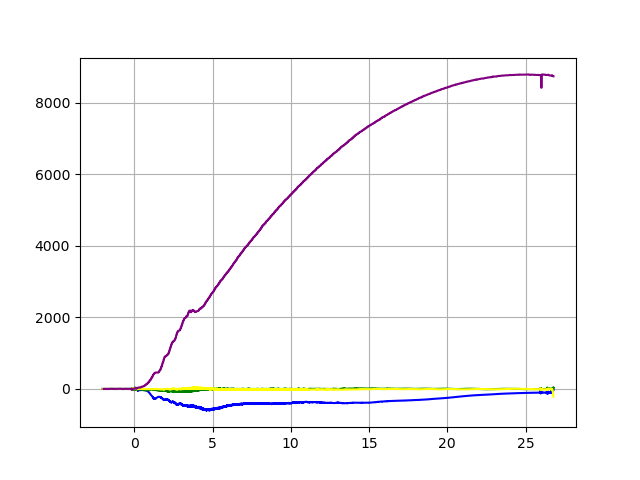

In [3]:
from scipy.signal import savgol_filter

# Let's find at which time the apogee occurred according to the low rate data
for i in range(0, len(df_lr['Flight_Time_(s)'])):
    if df_lr['Apogee'].iloc[i] >= 1:
        print(df_lr['Flight_Time_(s)'].iloc[i])
        df_lr = df_lr.iloc[:i]
        break

cutoff_time = df_lr['Flight_Time_(s)'].iloc[-1]

print(f'We are just interested in the first {cutoff_time} seconds of flight')

# Let's cut the HR data at a similar time
for i in range(0, len(df_hr['Flight_Time_(s)'])):
    if df_hr['Flight_Time_(s)'].iloc[i] >= cutoff_time:
        print(df_hr['Flight_Time_(s)'].iloc[i])
        df_hr = df_hr.iloc[:i]
        break


plt.clf()             # Clear the figure
#plt.plot(df_lr['Flight_Time_(s)'], df_lr['Future_Angle_(deg)'], color = 'red')
#plt.plot(df_lr['Flight_Time_(s)'], df_lr['Tilt_Angle_(deg)'], color = 'orange')
plt.plot(df_hr['Flight_Time_(s)'], df_hr['Gyro_X'], color = 'blue')
plt.plot(df_hr['Flight_Time_(s)'], df_hr['Gyro_Y'], color = 'green')
plt.plot(df_hr['Flight_Time_(s)'], df_hr['Gyro_Z'], color = 'yellow')
plt.plot(df_lr['Flight_Time_(s)'], df_lr['Baro_Altitude_AGL_(feet)'], color = 'purple')
#plt.axhline(y=5, color='yellow', linestyle='--', label='y = 5')
plt.grid()
plt.show()

#Given this data we can see that Gyro_X is on the upwards direction so we will not analyise it

time = df_hr['Flight_Time_(s)'].values
gyro_Y = df_hr['Gyro_Y'].values
gyro_Z = df_hr['Gyro_Z'].values


### Now lets analyse the frequency spectrum of the whole flight and see if we find something interesting...

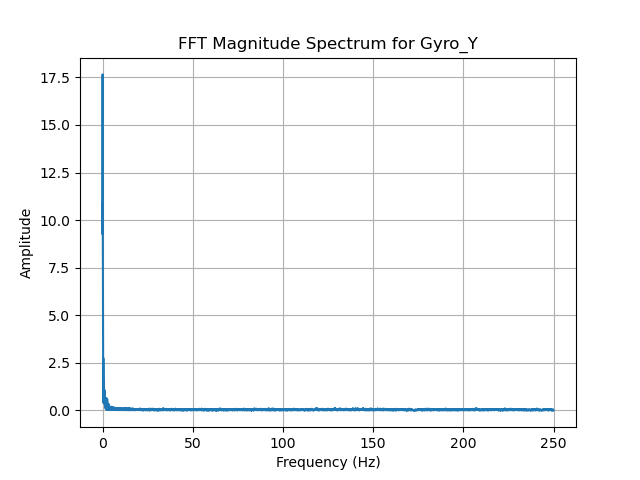

In [4]:
dt = time[1] - time[0]       # Time step
Fs = 1 / dt            # Sampling frequency

N = len(gyro_Y)
Y = np.fft.fft(gyro_Y)
freq = np.fft.fftfreq(N, d=dt)
plt.figure()
plt.plot(freq[:N//2], np.abs(Y[:N//2]) * 2 / N)  # One-sided magnitude
plt.title("FFT Magnitude Spectrum for Gyro_Y")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.grid()
plt.show()


We are not able to conclude much from this graph, so let's not cut the data again so we just analyse the first seconds of flight where the wiggle is visible in the video. That is...in the propulsion stage

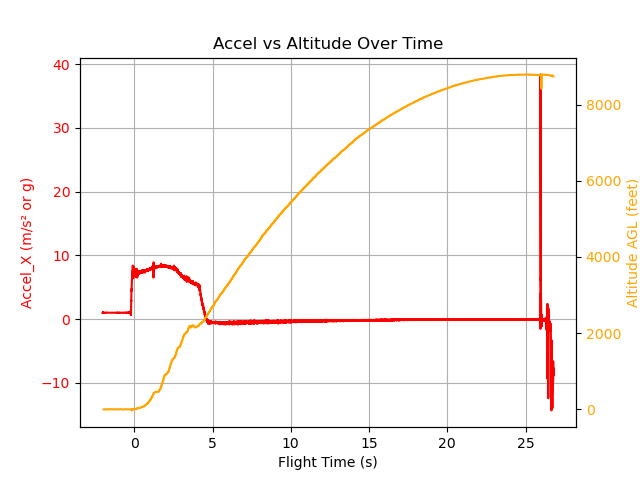

New time of interest: 4.61 s
The last time of interest is: 4.61 s


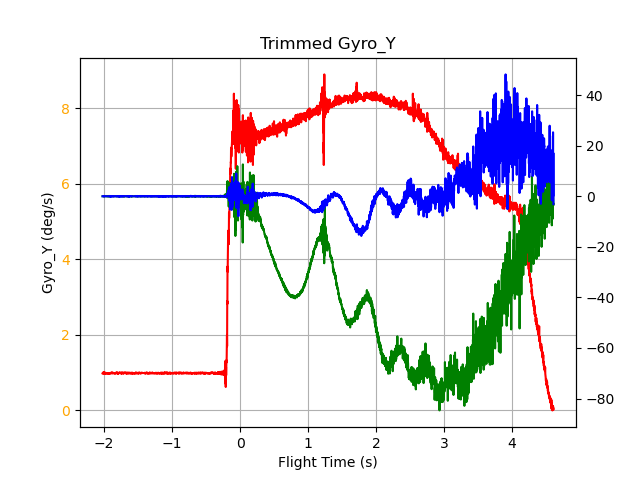

In [5]:
# ---------------------- First Plot ---------------------- #
fig1, ax1 = plt.subplots()  # Create a figure and the first Y-axis

# Plot on the first Y-axis (left)
ax1.plot(df_hr['Flight_Time_(s)'], df_hr['Accel_X'], color='red')
ax1.set_ylabel('Accel_X (m/s² or g)', color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.set_xlabel('Flight Time (s)')

# Create second Y-axis (right)
ax2 = ax1.twinx()
ax2.plot(df_lr['Flight_Time_(s)'], df_lr['Baro_Altitude_AGL_(feet)'], color='orange')
ax2.set_ylabel('Altitude AGL (feet)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

ax1.grid(True)
ax1.set_title('Accel vs Altitude Over Time')

plt.show()  # Show the first plot

# ---------------------- Slice Data ---------------------- #
for i in range(len(df_hr)):
    if df_hr['Accel_X'].iloc[i] < 0:
        print(f'New time of interest: {df_hr["Flight_Time_(s)"].iloc[i]:.2f} s')
        df_hr = df_hr.iloc[:i]
        break

print(f'The last time of interest is: {df_hr["Flight_Time_(s)"].iloc[-1]:.2f} s')

# ---------------------- Second Plot ---------------------- #
fig2, ax = plt.subplots()
ax.plot(df_hr['Flight_Time_(s)'], df_hr['Accel_X'], color='red')
ax.set_title('Trimmed Accel_X')
ax.set_xlabel('Flight Time (s)')
ax.set_ylabel('g')
ax.tick_params(axis='y', labelcolor='red')
axprime= ax.twinx()

axprime.plot(df_hr['Flight_Time_(s)'], df_hr['Gyro_Y'], color='green')
axprime.plot(df_hr['Flight_Time_(s)'], df_hr['Gyro_Z'], color='blue')
ax.set_title('Trimmed Gyro_Y')
ax.set_xlabel('Flight Time (s)')
ax.set_ylabel('Gyro_Y (deg/s)')
ax.tick_params(axis='y', labelcolor='orange')
ax.grid(True)

gyro_Y = df_hr['Gyro_Y'].values
gyro_Z = df_hr['Gyro_Z'].values
time = df_hr['Flight_Time_(s)'].values 

plt.show()  # Show the second plot

### Now that we have the data well cut, let's not filter it as Gyro_Y and Gyro_Z seem very noisy at some parts of the flight

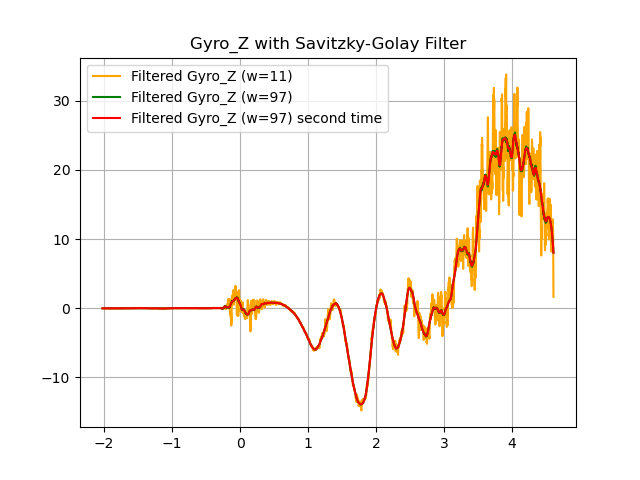

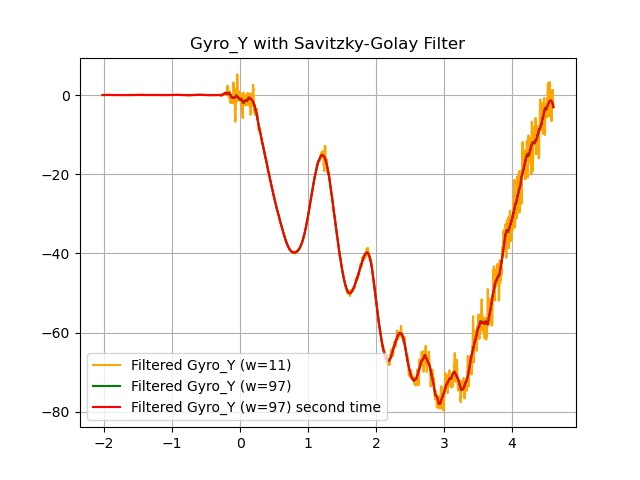

In [14]:
from scipy.signal import savgol_filter

gyro_Y = df_hr['Gyro_Y'].values
gyro_Z = df_hr['Gyro_Z'].values
time = df_hr['Flight_Time_(s)'].values 

# Apply Savitzky-Golay filter
gyro_Y_w11 = savgol_filter(gyro_Y, window_length=11, polyorder=3)
gyro_Y_w97 = savgol_filter(gyro_Y, window_length=97, polyorder=3)
# We have a very high quiality signal for Gyro_Y, so let's not filter it again
gyro_Y2 = savgol_filter(gyro_Y_w97, window_length=21, polyorder=3)

fig, ax = plt.subplots()
#ax.plot(time, gyro_Y, label='Original Gyro_Y', color='blue')
ax.plot(time, gyro_Y_w11, label='Filtered Gyro_Y (w=11)', color='orange')
ax.plot(time, gyro_Y_w97, label='Filtered Gyro_Y (w=97)', color='green')
ax.plot(time, gyro_Y2, label='Filtered Gyro_Y (w=97) second time', color='red')
ax.set_title('Gyro_Y with Savitzky-Golay Filter')
ax.legend()
ax.grid()

# Apply Savitzky-Golay filter
gyro_Z_w11 = savgol_filter(gyro_Z, window_length=11, polyorder=3)
gyro_Z_w97 = savgol_filter(gyro_Z, window_length=97, polyorder=3)
# We have a very high quiality signal for Gyro_Y, so let's not filter it again
gyro_Z2 = savgol_filter(gyro_Z_w97, window_length=21, polyorder=3)

fig, ax1 = plt.subplots()
#ax1.plot(time, gyro_Z, label='Original Gyro_Z', color='blue')
ax1.plot(time, gyro_Z_w11, label='Filtered Gyro_Z (w=11)', color='orange')
ax1.plot(time, gyro_Z_w97, label='Filtered Gyro_Z (w=97)', color='green')
ax1.plot(time, gyro_Z2, label='Filtered Gyro_Z (w=97) second time', color='red')
ax1.set_title('Gyro_Z with Savitzky-Golay Filter')
ax1.legend()
ax1.grid()

plt.show()


### Let's take the FFT again

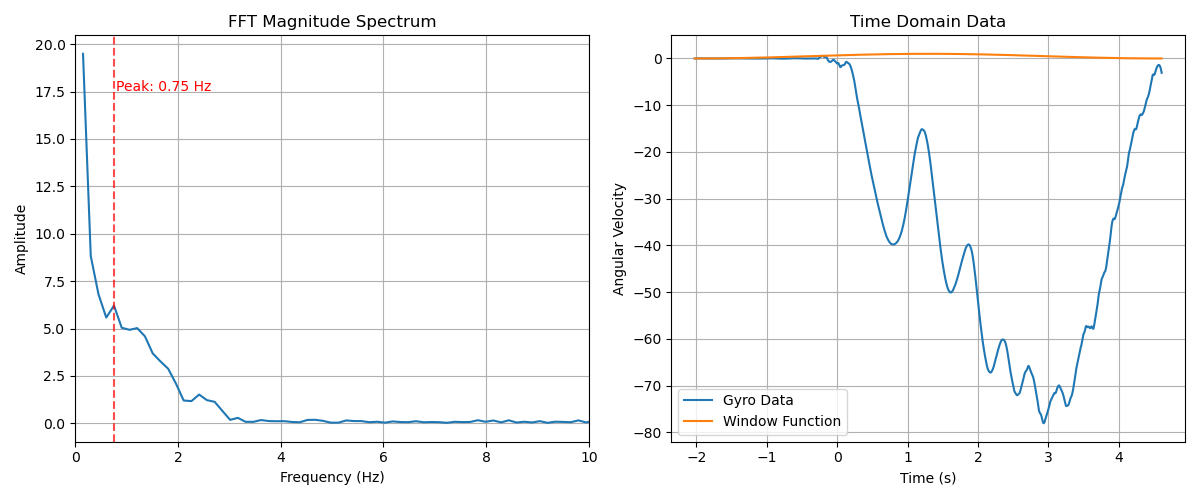

Dominant wiggle frequency: 0.75 Hz


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Assuming 'time' and 'gyro_Y2' are your time and gyro data vectors
dt = time[1] - time[0]  # Time step
Fs = 1 / dt              # Sampling frequency

# Preprocess data: remove DC offset and linear trend
detrended_data = signal.detrend(gyro_Y, type='linear')  # Removes DC + linear trend

# Apply windowing to reduce spectral leakage
N = len(detrended_data)
window = np.hanning(N)  # Hanning window for better spectral resolution
windowed_data = detrended_data * window

# Perform FFT with proper scaling
Y = np.fft.fft(windowed_data)
freq = np.fft.fftfreq(N, d=dt)

# Calculate single-sided amplitude spectrum (positive frequencies only)
positive_mask = freq > 0  # Use frequencies >0 to ignore DC and negatives
positive_freq = freq[positive_mask]
magnitude = np.abs(Y) * 2 / np.sum(window)  # Corrected amplitude scaling
positive_mag = magnitude[positive_mask]

# Find dominant frequency (ignore near-DC components)
search_mask = (positive_freq > 0.5)  # Exclude frequencies below 0.5 Hz
if np.any(search_mask):
    peak_idx = np.argmax(positive_mag[search_mask])
    wiggle_freq = positive_freq[search_mask][peak_idx]
else:
    wiggle_freq = positive_freq[np.argmax(positive_mag)]

# Create figure with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# ------------------------------------------
# First Subplot: Frequency Domain
# ------------------------------------------
ax1.plot(positive_freq, positive_mag)
ax1.set_title("FFT Magnitude Spectrum")
ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel("Amplitude")
ax1.grid(True)
ax1.set_xlim(0, 10)  # Focus on 0-10 Hz range

# Add marker for detected peak
ax1.axvline(wiggle_freq, color='r', linestyle='--', alpha=0.7)
ax1.text(wiggle_freq*1.05, max(positive_mag)*0.9, 
         f'Peak: {wiggle_freq:.2f} Hz', color='red')

# ------------------------------------------
# Second Subplot: Time Domain
# ------------------------------------------
ax2.plot(time, gyro_Y2, label='Gyro Data')
ax2.plot(time, window, label='Window Function')
ax2.set_title("Time Domain Data")
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Angular Velocity")
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

print(f"Dominant wiggle frequency: {wiggle_freq:.2f} Hz")

When we analyze the video footage, we can approximate a frequency just below 1 Hz. This corresponds closely to the FFT above as we have a small peak at 0.75 Hz, still we see a maximum value close to 0 Hz in out graph, so to further account for this value (to eliminate it), we can remove the general semi-quadratic behavior of the gyroscopic data by running the data through a high-pass filter so we are left with the high frequency data that corresponds to the wiggle of the rocket on the way up.

### 1. High pass filter

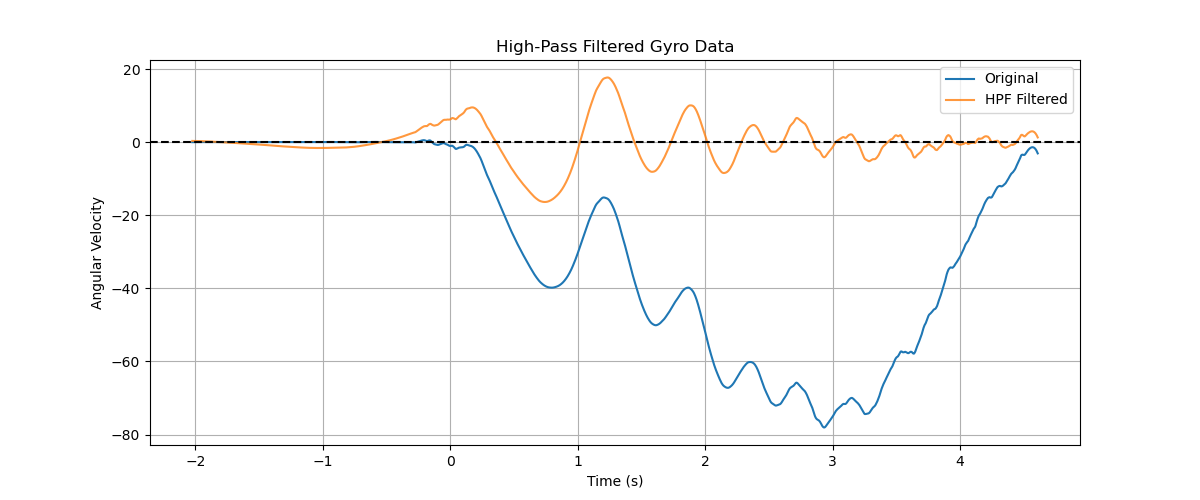

Dominant wiggle frequency after HPF: 0.7537 Hz


In [27]:
from scipy.signal import butter, filtfilt

# Step 1: Design High-Pass Filter
cutoff = 0.4  # Hz (adjust based on wiggle frequency)
order = 4     # Filter sharpness (higher = steeper cutoff)
sampling_rate = 1 / (time[1] - time[0])  # 1 / dt

# Create Butterworth HPF
b, a = butter(order, cutoff, btype='highpass', fs=sampling_rate)

# Step 2: Apply Zero-Phase Filtering (no time lag)
gyro_Y3 = filtfilt(b, a, gyro_Y2)

fig, ax = plt.subplots(figsize=(12, 5))
# Step 3: Plot Results
ax.set_title("High-Pass Filtered Gyro Data")
ax.plot(time, gyro_Y2, label='Original')
ax.plot(time, gyro_Y3, label='HPF Filtered', alpha=0.8)
ax.axhline(0, color='k', linestyle='--')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Angular Velocity')
ax.legend()
ax.grid(True)
plt.show()

window = np.hanning(len(gyro_Y2))  # Hanning window for better spectral resolution
# Perform FFT on both original and filtered data
windowed_gyro_Y2 = gyro_Y2 * window
windowed_filtered_data_Y = gyro_Y3 * window

original_fft_Y = np.abs(np.fft.fft(windowed_gyro_Y2))
filtered_fft_Y = np.abs(np.fft.fft(windowed_filtered_data_Y))
freqs = np.fft.fftfreq(len(time), d=1/sampling_rate)

# Calculate single-sided amplitude spectrum (positive frequencies only)
positive_mask = freqs > 0  # Use frequencies >0 to ignore DC and negatives
positive_freqs = freq[positive_mask]


original_mag_Y = np.abs(original_fft_Y) * 2 / np.sum(window)  # Corrected amplitude scaling
filtered_mag_Y = np.abs(filtered_fft_Y) * 2 / np.sum(window)  # Corrected amplitude scaling

original_positive_mag_Y = original_mag_Y[positive_mask]
filtered_positive_mag_Y = filtered_mag_Y[positive_mask]

peak_idx = np.argmax(filtered_positive_mag_Y)
wiggle_freq_Y = positive_freqs[peak_idx]

print(f"Dominant wiggle frequency after HPF: {wiggle_freq_Y:.4f} Hz")

Let's to the same for the gyroscopic data in the Z-axis

Dominant wiggle frequency after HPF: 1.6581 Hz


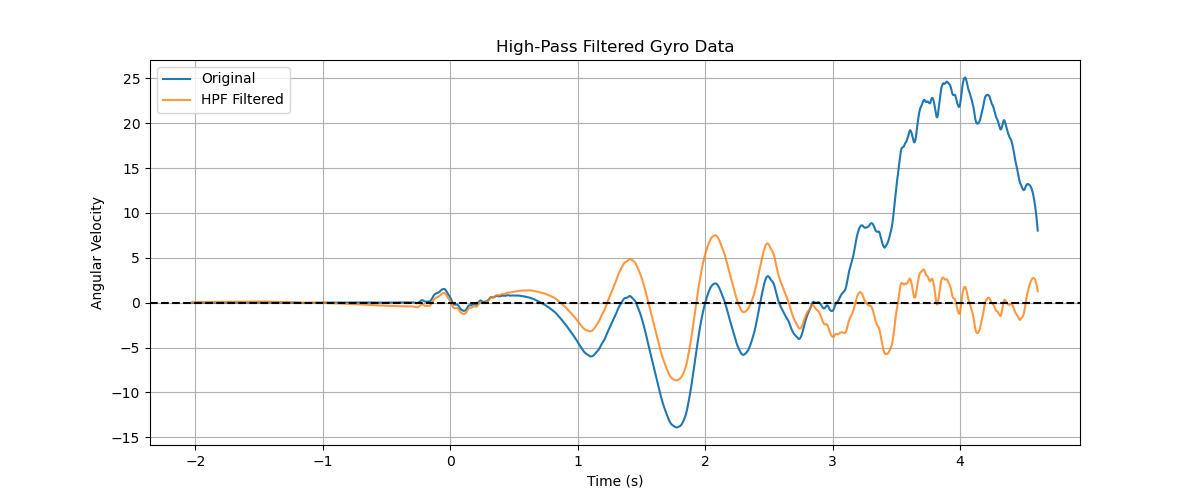

In [29]:
from scipy.signal import butter, filtfilt

# Step 1: Design High-Pass Filter
cutoff = 0.4  # Hz (adjust based on wiggle frequency)
order = 4     # Filter sharpness (higher = steeper cutoff)
sampling_rate = 1 / (time[1] - time[0])  # 1 / dt

# Create Butterworth HPF
b, a = butter(order, cutoff, btype='highpass', fs=sampling_rate)

# Step 2: Apply Zero-Phase Filtering (no time lag)
gyro_Z3 = filtfilt(b, a, gyro_Z2)


fig, ax = plt.subplots(figsize=(12, 5))
# Step 3: Plot Results
ax.set_title("High-Pass Filtered Gyro Data")
ax.plot(time, gyro_Z2, label='Original')
ax.plot(time, gyro_Z3, label='HPF Filtered', alpha=0.8)
ax.axhline(0, color='k', linestyle='--')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Angular Velocity')
ax.legend()
plt.grid(True)

# Step 4: Compare FFTs (Optional)

window = np.hanning(len(gyro_Z2))  # Hanning window for better spectral resolution
# Perform FFT on both original and filtered data
windowed_gyro_Z2 = gyro_Z2 * window
windowed_filtered_data_Z = gyro_Z3 * window

original_fft_Z = np.abs(np.fft.fft(windowed_gyro_Z2))
filtered_fft_Z = np.abs(np.fft.fft(windowed_filtered_data_Z))
freqs = np.fft.fftfreq(len(time), d=1/sampling_rate)

# Calculate single-sided amplitude spectrum (positive frequencies only)
positive_mask = freqs > 0  # Use frequencies >0 to ignore DC and negatives
positive_freqs = freq[positive_mask]


original_mag_Z = np.abs(original_fft_Z) * 2 / np.sum(window)  # Corrected amplitude scaling
filtered_mag_Z = np.abs(filtered_fft_Z) * 2 / np.sum(window)  # Corrected amplitude scaling

original_positive_mag_Z = original_mag_Z[positive_mask]
filtered_positive_mag_Z = filtered_mag_Z[positive_mask]

peak_idx = np.argmax(filtered_positive_mag_Z)
wiggle_freq_Z = positive_freqs[peak_idx]


print(f"Dominant wiggle frequency after HPF: {wiggle_freq_Z:.4f} Hz")

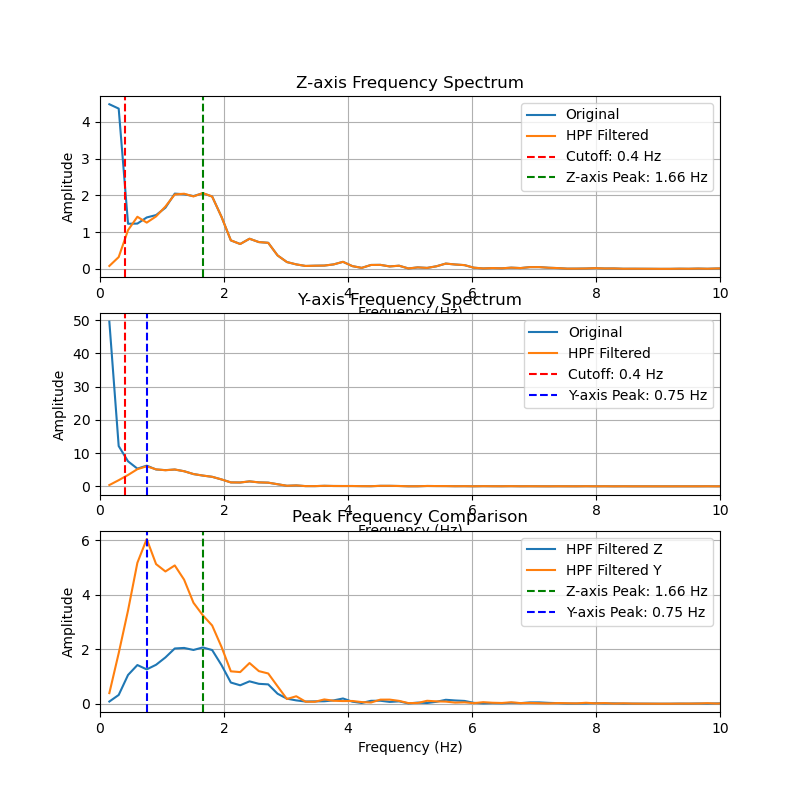

In [34]:
# Create figure with 1x3 subplot layout
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 8))
# ------------------------------------------
# Subplot 1: Z-axis Frequency Domain
# ------------------------------------------
ax1.plot(positive_freqs, original_positive_mag_Z, label='Original')
ax1.plot(positive_freqs, filtered_positive_mag_Z, label='HPF Filtered')
ax1.axvline(cutoff, color='r', linestyle='--', label=f'Cutoff: {cutoff} Hz')
ax1.axvline(wiggle_freq_Z, color='green', linestyle='--', label=f'Z-axis Peak: {wiggle_freq_Z:.2f} Hz')
ax1.set_title("Z-axis Frequency Spectrum")
ax1.set_xlim(0, 10)
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Amplitude')
ax1.legend()
ax1.grid(True)

# ------------------------------------------
# Subplot 2: Y-axis Frequency Domain
# ------------------------------------------
ax2.plot(positive_freqs, original_positive_mag_Y, label='Original')
ax2.plot(positive_freqs, filtered_positive_mag_Y, label='HPF Filtered')
ax2.axvline(cutoff, color='r', linestyle='--', label=f'Cutoff: {cutoff} Hz')
ax2.axvline(wiggle_freq_Y, color='blue', linestyle='--', label=f'Y-axis Peak: {wiggle_freq_Y:.2f} Hz')
ax2.set_title("Y-axis Frequency Spectrum")
ax2.set_xlim(0, 10)
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Amplitude')
ax2.legend()
ax2.grid(True)

# ------------------------------------------
# Subplot 3: Combined Peaks Comparison
# ------------------------------------------
ax3.plot(positive_freqs, filtered_positive_mag_Z, label='HPF Filtered Z')
ax3.plot(positive_freqs, filtered_positive_mag_Y, label='HPF Filtered Y')
ax3.axvline(wiggle_freq_Z, color='green', linestyle='--', label=f'Z-axis Peak: {wiggle_freq_Z:.2f} Hz')
ax3.axvline(wiggle_freq_Y, color='blue', linestyle='--', label=f'Y-axis Peak: {wiggle_freq_Y:.2f} Hz')
ax3.set_title("Peak Frequency Comparison")
ax3.set_xlim(0, 10)
ax3.set_xlabel('Frequency (Hz)')
ax3.set_ylabel('Amplitude')
ax3.legend()
ax3.grid(True)

plt.show()

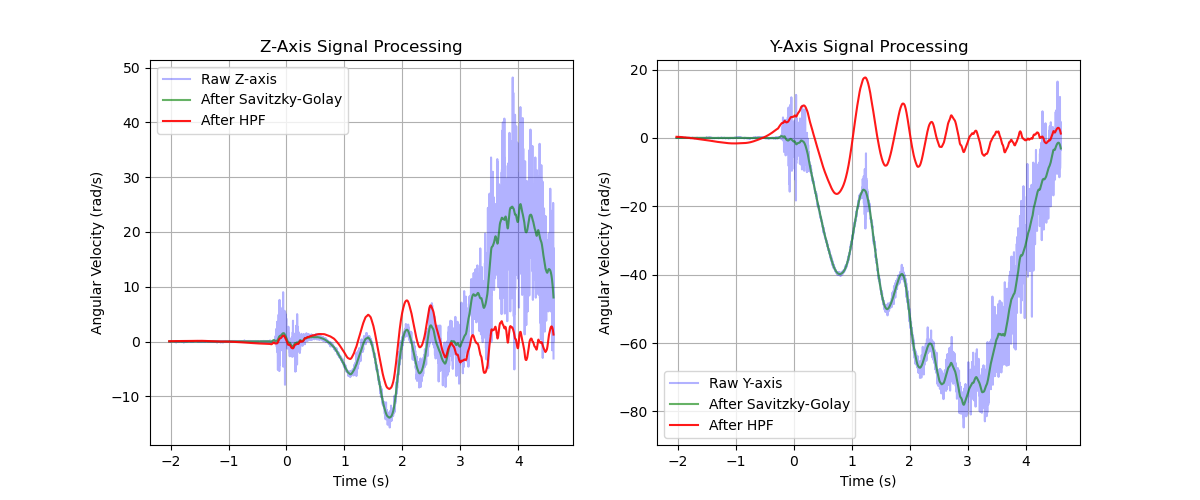

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# ------------------------------------------
# Z-Axis Processing
# ------------------------------------------
ax1.plot(time, gyro_Z, 'b-', alpha=0.3, label='Raw Z-axis')
ax1.plot(time, gyro_Z2, 'g-', alpha=0.6, label='After Savitzky-Golay')
ax1.plot(time, gyro_Z3, 'r-', alpha=0.9, label='After HPF')
ax1.set_title('Z-Axis Signal Processing')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Angular Velocity (rad/s)')
ax1.grid(True)
ax1.legend()

# ------------------------------------------
# Y-Axis Processing
# ------------------------------------------
ax2.plot(time, gyro_Y, 'b-', alpha=0.3, label='Raw Y-axis')
ax2.plot(time, gyro_Y2, 'g-', alpha=0.6, label='After Savitzky-Golay')
ax2.plot(time, gyro_Y3, 'r-', alpha=0.9, label='After HPF')
ax2.set_title('Y-Axis Signal Processing')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Angular Velocity (rad/s)')
ax2.grid(True)
ax2.legend()


plt.show()

### Finally, let's estimate the damping ratio of the angular velocity in the Y axis 

Estimated damping ratio ζ = 0.022


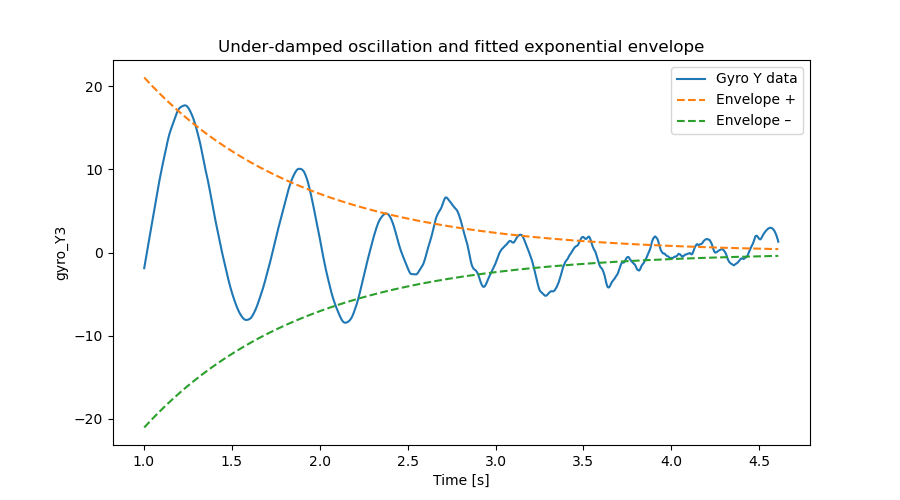

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# — assume you already have:
#   time      : 1D array of time stamps
#   gyro_Y3   : 1D array of gyroscope Y‑axis readings

# 1) isolate t > 1 s
mask   = time > 1.0
t_fit  = time[mask]
y_fit  = gyro_Y3[mask]

# 2) detect peaks (positive crests)
peaks, _    = find_peaks(y_fit)
peak_t      = t_fit[peaks]
peak_vals   = y_fit[peaks]

# 3) fit log‐linear model to |peak_vals| vs. time
logp   = np.log(np.abs(peak_vals))
slope, intercept = np.polyfit(peak_t, logp, 1)
lambda_      = -slope       # decay constant
A0     = np.exp(intercept)  # amplitude at t=0

# 4) estimate damped freq and ζ
periods = np.diff(peak_t)
T_avg   = np.mean(periods)
omega_d     = 2*np.pi / T_avg
omega_n     = np.sqrt(lambda_**2 + omega_d**2)
zeta = lambda_ / omega_n

print(f"Estimated damping ratio ζ = {zeta:.3f}")

# 5) plot data + fitted envelopes
fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(t_fit, y_fit, label="Gyro Y data")
ax.plot(t_fit,  A0*np.exp(-lambda_*t_fit),   '--', label="Envelope +")
ax.plot(t_fit, -A0*np.exp(-lambda_*t_fit),   '--', label="Envelope –")
ax.set_xlabel("Time [s]")
ax.set_ylabel("gyro_Y3")
ax.set_title("Under‑damped oscillation and fitted exponential envelope")
ax.legend()
plt.show()


Estimated damping ratio ζ (gyro_Z3) = 0.013


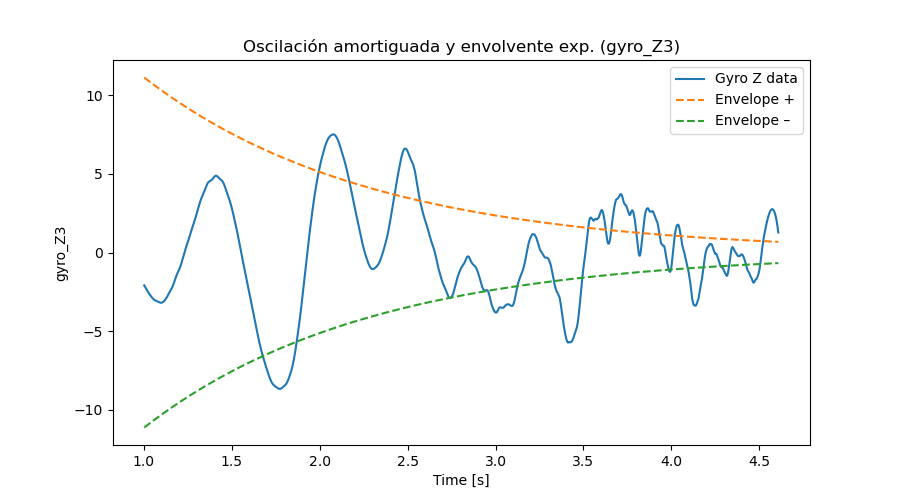

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# — asume que ya tienes:
#   time      : array de tiempos
#   gyro_Z3   : array de la señal Z del giroscopio

# 1) aislar t > 1 s
mask   = time > 1.0
t_fit  = time[mask]
z_fit  = gyro_Z3[mask]

# 2) detectar picos positivos
peaks, _   = find_peaks(z_fit)
peak_t     = t_fit[peaks]
peak_vals  = z_fit[peaks]

# 3) ajuste log‑lineal para la envolvente
logp    = np.log(np.abs(peak_vals))
slope, intercept = np.polyfit(peak_t, logp, 1)
lambda_       = -slope
A0      = np.exp(intercept)

# 4) frecuencia amortiguada y ratio de amortiguamiento ζ
periods = np.diff(peak_t)
T_avg   = np.mean(periods)
omega_d     = 2*np.pi / T_avg
omega_n     = np.sqrt(lambda_**2 + omega_d**2)
zeta       = lambda_ / omega_n

print(f"Estimated damping ratio ζ (gyro_Z3) = {zeta:.3f}")


# 5) gráficar datos y envolventes ajustadas
fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(t_fit, z_fit, label="Gyro Z data")
ax.plot(t_fit,  A0*np.exp(-lambda_*t_fit),   '--', label="Envelope +")
ax.plot(t_fit, -A0*np.exp(-lambda_*t_fit),   '--', label="Envelope –")
ax.set_xlabel("Time [s]")
ax.set_ylabel("gyro_Z3")
ax.set_title("Oscilación amortiguada y envolvente exp. (gyro_Z3)")
ax.legend()
plt.show()
